# NARX shoreline model results
This notebook is designed to plot 

In [21]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys, os, re
import glob, pickle
import numpy as np
import pandas as pd
from shoreNARX import TrainingClass
from shoreNARX.model_class import calc_performance_
from shoreNARX.plotting import (
    plot_compare_datareq, plot_compare_sattest
)
# from shoreNARX.analyses import ()

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
baseLoc = '.'
# set pandas print format to 3 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Report model performance 
With optimised hyperparams and 5-fold CV.

trainObj.statsOut gives a [[{} * CV_folds] * random_states] object

First define a function that loads the model results for a given config file.

In [24]:
def load_model_results(config_file, datareq=False):
    # init object
    config_path = os.path.join(baseLoc,'config',config_file)
    trainObj = TrainingClass(**{'baseDir':baseLoc,'config':config_path})
    # train as per config
    trainObj.load_cv_test()

    # get the train/test splits
    ttCombs = np.array(trainObj.trainCombs)
    if datareq:
        # get the fold and data perc
        ttFold = np.argmax(ttCombs==1,axis=1)/2
        # get data perc
        ttPerc = np.sum(ttCombs==2,axis=1)*100/ttCombs.shape[1]
        combsData = pd.DataFrame(
            {'fold':ttFold,'perc':ttPerc,'num':np.arange(ttCombs.shape[0])}
        )
    else:
        ttFold = np.argmax(ttCombs==1,axis=1)
        combsData = pd.DataFrame(
            {'fold':ttFold,'num':ttFold}
        )


    # data collector
    dataCollector = []

    # get the performance metrics for each fold and ensemble
    for thisFold in np.arange(trainObj.statsOut[0].__len__()):
        for thisEnsemble in np.arange(trainObj.statsOut.__len__()):
            tmpRMSE, tmpNMSE, tmpR, tmpR2 = calc_performance_(
                trainObj.statsOut[thisEnsemble][thisFold]['test']['modY'],
                trainObj.statsOut[thisEnsemble][thisFold]['test']['obsY']
            )
            # little indicative check on the training compared to teting data.
            trainRange = trainObj.statsOut[thisEnsemble][thisFold]['train']['obsY'].quantile(0.975).values[0] - trainObj.statsOut[thisEnsemble][thisFold]['train']['obsY'].quantile(0.025).values[0]
            testRange = trainObj.statsOut[thisEnsemble][thisFold]['test']['obsY'].quantile(0.975).values[0] - trainObj.statsOut[thisEnsemble][thisFold]['test']['obsY'].quantile(0.025).values[0]
            # append to data collector
            dataCollector.append(
                {
                    'testRMSE': tmpRMSE,
                    'testNMSE': tmpNMSE,
                    'testR': tmpR,
                    'testR2': tmpR2,
                    'trainRange': trainRange,
                    'testRange': testRange,
                    'rangeRatio': testRange/trainRange,
                    'num': thisFold,
                    'ensemble': thisEnsemble,
                }
            )

    # collate dataCollector into a dataframe
    performanceData = pd.DataFrame(dataCollector)
    performanceData = pd.merge(performanceData,combsData,left_on='num',right_on='num')
    performanceData['site'] = trainObj.site

    print('Performance by fold:')
    # now calculate the by fold std
    std_byFold = performanceData.drop(columns='site').groupby(by='fold').std()
    std_byFold = std_byFold[['testRMSE','testNMSE','testR','testR2']]
    std_byFold.columns = ['(std testRMSE)','(std testNMSE)','(std testR)','(std testR3)']
    byFold = pd.concat([
        performanceData.drop(columns='site').groupby(by='fold').mean(),
        std_byFold
    ], axis=1).drop(columns=['ensemble'])
    display(byFold)


    return trainObj, performanceData

Narrabeen performance check

In [25]:
case = 'datareq'

print('#'*80)
print('Narrabeen')
_, narra_datareq_perf = load_model_results('narra_{}_config.json'.format(case),datareq=True)
print('#'*80)
print('Tairua')
_, tairua_datareq_perf = load_model_results('tairua_{}_config.json'.format(case), datareq=True)

################################################################################
Narrabeen
Performance by fold:


,testRMSE,testNMSE,testR,testR2,trainRange,testRange,rangeRatio,num,perc,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,,,,,
0.000,8.721,1.317,0.615,0.302,38.803,28.380,0.771,3.500,45.000,3.414,1.135,0.182,0.053
1.000,7.139,0.736,0.715,0.308,37.683,31.919,0.898,11.500,45.000,2.175,0.520,0.106,0.086
2.000,6.245,0.630,0.784,0.043,40.060,33.155,0.851,19.500,45.000,2.539,0.603,0.122,0.112
3.000,8.645,1.240,0.779,0.342,35.733,30.818,0.892,27.500,45.000,4.041,1.388,0.126,0.049
4.000,8.113,0.859,0.730,0.148,35.877,37.535,1.119,35.500,45.000,3.515,0.986,0.116,0.065


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,trainRange,testRange,rangeRatio,num,perc,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,,,,,
0.000,5.055,0.664,0.611,0.276,20.129,21.449,1.079,3.500,45.000,0.466,0.122,0.098,0.058
1.000,4.733,1.140,0.409,0.110,20.927,17.601,0.853,11.500,45.000,0.758,0.370,0.152,0.224
2.000,5.111,0.641,0.633,0.300,19.421,24.586,1.282,19.500,45.000,0.565,0.143,0.141,0.065
3.000,4.118,0.727,0.585,0.167,21.214,20.133,0.955,27.500,45.000,0.467,0.170,0.095,0.106
4.000,5.323,1.176,0.250,-0.025,20.965,18.303,0.878,35.500,45.000,0.393,0.175,0.096,0.108


# Plot the model performance
## Data requirements

In [26]:
comb_datareq = pd.concat([narra_datareq_perf,tairua_datareq_perf],axis=0)
comb_datareq.head()

,testRMSE,testNMSE,testR,testR2,trainRange,testRange,rangeRatio,num,ensemble,fold,perc,site
0,6.929,0.722,0.536,0.214,16.536,28.380,1.716,0,0,0.000,10.000,narra
1,6.722,0.679,0.579,0.261,16.536,28.380,1.716,0,1,0.000,10.000,narra
2,9.250,1.286,0.388,0.267,32.388,28.380,0.876,0,2,0.000,10.000,narra
3,14.964,3.366,0.644,0.176,31.953,28.380,0.888,0,3,0.000,10.000,narra
4,14.774,3.281,0.679,0.193,31.953,28.380,0.888,0,4,0.000,10.000,narra


In [27]:
comb_datareq.shape

(1600, 12)

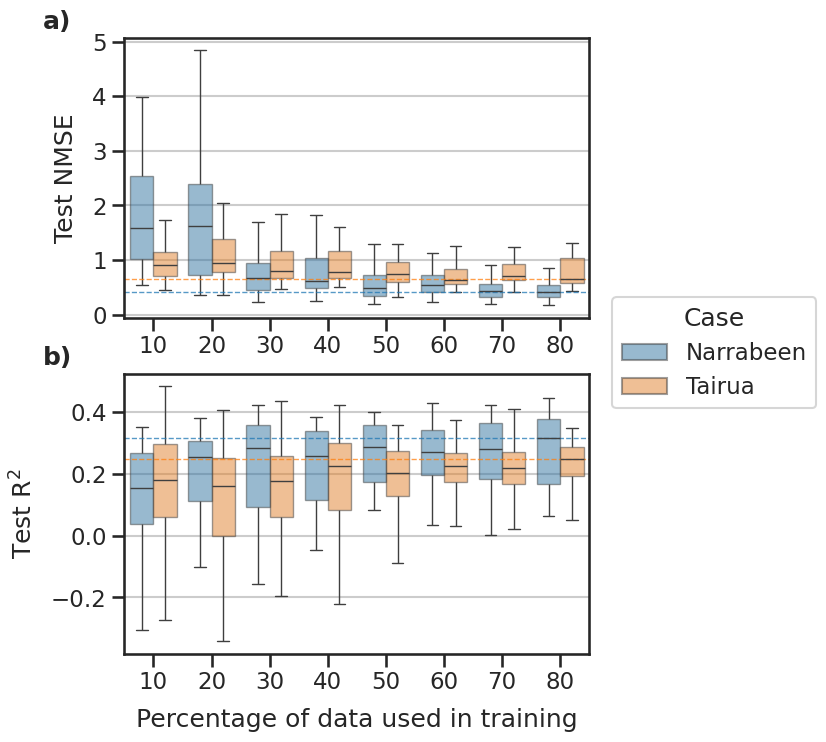

In [28]:
plot_compare_datareq(comb_datareq, savebool=True, showfliers=False)

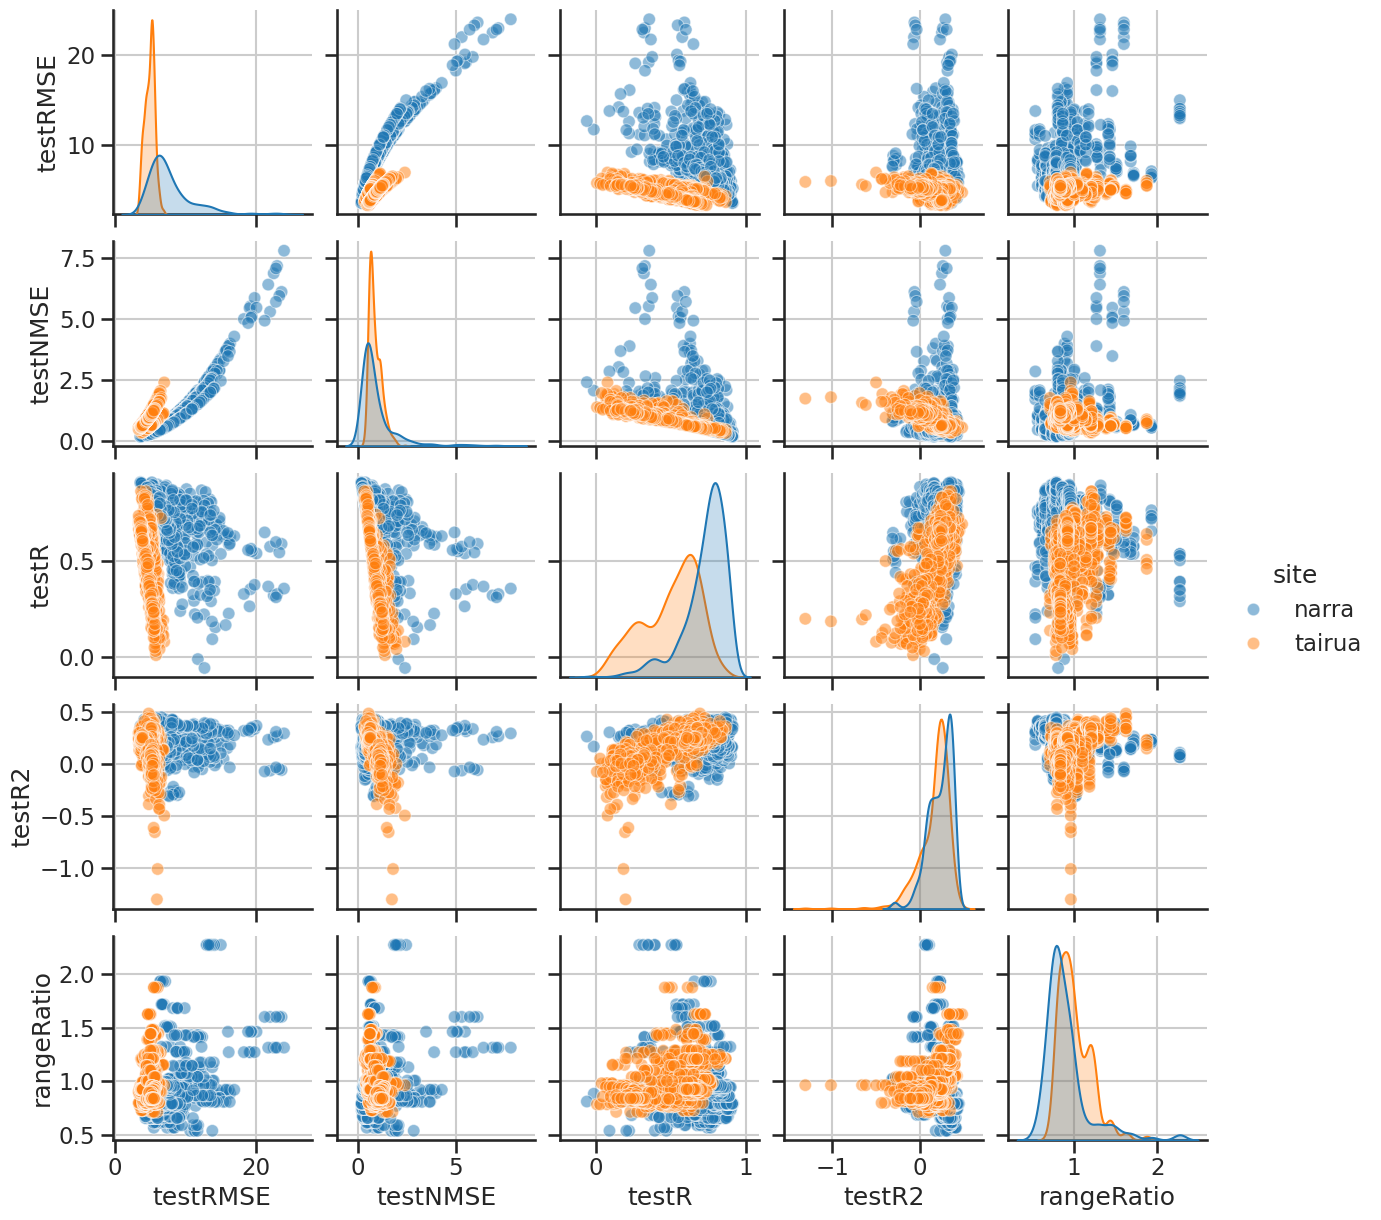

In [29]:
sns.pairplot(
    comb_datareq.drop(columns=['num','fold','ensemble','perc','trainRange','testRange']),
    hue='site',
    plot_kws={'alpha':0.5}
)

## Satellite data simulation

In [8]:
# 20% data
case = 'base'

print('#'*80)
print('Narrabeen')
_, narra_base_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
_, tairua_base_perf = load_model_results('tairua_{}_config.json'.format(case))


# 20% data
case = 'sattest1'

print('#'*80)
print('Narrabeen')
_, narra_sattest1_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
_, tairua_sattest1_perf = load_model_results('tairua_{}_config.json'.format(case))

# 20% + noise
case = 'sattest2'

print('#'*80)
print('Narrabeen')
_, narra_sattest2_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
_, tairua_sattest2_perf = load_model_results('tairua_{}_config.json'.format(case))

################################################################################
Narrabeen
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,
0,5.807,0.516,0.783,0.326,0.000,0.790,0.145,0.044,0.029
1,5.567,0.411,0.776,0.379,1.000,0.241,0.036,0.026,0.017
2,4.072,0.232,0.889,0.123,2.000,0.351,0.041,0.017,0.026
3,6.993,0.690,0.869,0.380,3.000,1.339,0.245,0.020,0.036
4,6.224,0.427,0.783,0.198,4.000,0.336,0.046,0.030,0.028


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,
0,4.560,0.538,0.722,0.291,0.000,0.276,0.064,0.049,0.028
1,4.386,0.956,0.435,0.216,1.000,0.224,0.097,0.071,0.034
2,5.115,0.634,0.658,0.306,2.000,0.162,0.040,0.046,0.025
3,3.802,0.613,0.632,0.230,3.000,0.149,0.049,0.045,0.023
4,5.322,1.170,0.253,-0.032,4.000,0.184,0.081,0.045,0.081


################################################################################
Narrabeen
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,
0,5.663,0.487,0.785,0.218,0.000,0.609,0.109,0.031,0.018
1,7.575,0.761,0.503,0.101,1.000,0.391,0.079,0.066,0.013
2,5.032,0.353,0.828,0.103,2.000,0.337,0.047,0.030,0.016
3,6.904,0.669,0.763,0.142,3.000,1.219,0.243,0.037,0.022
4,7.524,0.626,0.651,0.130,4.000,0.559,0.092,0.071,0.018


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,
0,5.073,0.665,0.600,0.164,0.000,0.230,0.059,0.054,0.034
1,5.427,1.466,0.231,-0.069,1.000,0.333,0.181,0.038,0.104
2,5.548,0.747,0.524,0.226,2.000,0.218,0.057,0.063,0.024
3,3.888,0.643,0.616,0.179,3.000,0.255,0.087,0.082,0.026
4,5.482,1.241,0.167,0.004,4.000,0.172,0.077,0.069,0.033


################################################################################
Narrabeen
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,
0,9.619,1.434,0.524,-0.954,0.000,1.738,0.527,0.092,0.388
1,8.712,1.021,0.436,-0.597,1.000,1.167,0.276,0.168,0.257
2,8.228,0.960,0.437,-0.847,2.000,1.237,0.284,0.177,0.297
3,9.675,1.322,0.443,-0.811,3.000,1.883,0.527,0.236,0.388
4,11.111,1.379,0.327,-1.212,4.000,1.426,0.342,0.214,0.440


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,num,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,,
0,6.369,1.058,0.371,-0.422,0.000,0.709,0.224,0.145,0.173
1,7.236,2.645,0.166,-1.219,1.000,1.008,0.758,0.126,0.924
2,6.777,1.127,0.318,-0.183,2.000,0.793,0.263,0.191,0.146
3,5.339,1.225,0.388,-0.367,3.000,0.654,0.315,0.151,0.216
4,6.635,1.838,0.169,-0.863,4.000,0.741,0.393,0.145,0.361


In [9]:
narra_sattest1_perf

,testRMSE,testNMSE,testR,testR2,num,ensemble,fold,site
0,5.719,0.492,0.809,0.232,0,0,0,narra
1,5.521,0.458,0.792,0.230,0,1,0,narra
2,5.111,0.393,0.810,0.222,0,2,0,narra
3,5.188,0.405,0.788,0.194,0,3,0,narra
4,5.832,0.511,0.813,0.225,0,4,0,narra
...,...,...,...,...,...,...,...,...
95,7.604,0.636,0.604,0.123,4,15,4,narra
96,7.677,0.648,0.612,0.132,4,16,4,narra
97,8.565,0.807,0.526,0.118,4,17,4,narra
98,7.861,0.680,0.642,0.111,4,18,4,narra


In [14]:
sattest_comp = pd.concat([
    narra_base_perf.assign(site='narra').assign(case='All data'),
    narra_sattest1_perf.assign(site='narra').assign(case='20%'),
    narra_sattest2_perf.assign(site='narra').assign(case='20% + Noise'),
    tairua_base_perf.assign(site='tairua').assign(case='All data'),
    tairua_sattest1_perf.assign(site='tairua').assign(case='20%'),
    tairua_sattest2_perf.assign(site='tairua').assign(case='20% + Noise')
])


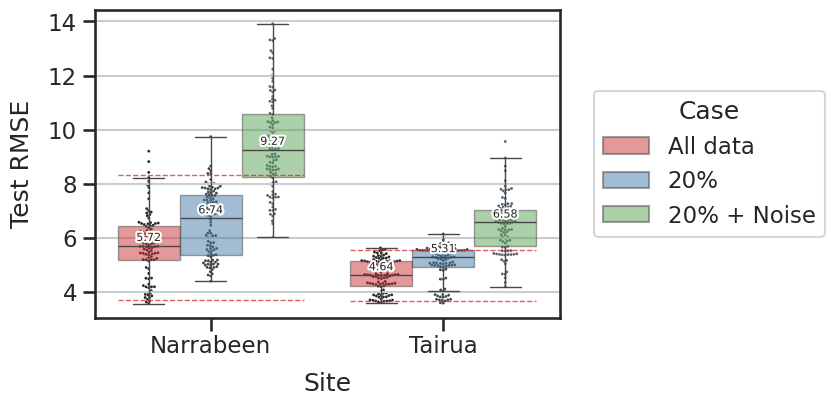

In [30]:
plot_compare_sattest(sattest_comp, savebool=True)